# Tutorial: Transfer Function Measurement

This tutorial demonstrates how to use `gwexpy` to estimate the transfer function of a system from measured data,
fit a physical model to the transfer function, and identify system parameters.

**Scenario:**
We inject white noise into a mechanical vibration system (or electrical circuit) and measure its response.
From this input-output data, we will determine the system's resonance frequency $f_0$ and quality factor $Q$.

**Workflow:**
1.  **Data generation**: Simulate an input signal (white noise) and the system output (resonant system response + measurement noise).
2.  **Transfer function estimation**: Calculate the transfer function and coherence from the input-output time series data and plot the Bode plot.
3.  **Model fitting**: Fit a theoretical model (such as a Lorentzian function) to the estimated transfer function to extract system parameters.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from gwexpy import TimeSeries
from gwexpy.plot import Plot

/home/washimi/work/gwexpy/.venv-docs-exec/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


## 1. Generating Experimental Data (Simulation)

We will conduct a virtual experiment.
*   **System**: Second-order resonant system (harmonic oscillator)
    *   Resonance frequency $f_0 = 300$ Hz
    *   Quality factor $Q = 50$
*   **Input**: White noise
*   **Measurement**: Sampling frequency 2048 Hz, duration 60 seconds

The output signal will also include measurement noise.

Input data shape: (122880,)
Output data shape: (122880,)


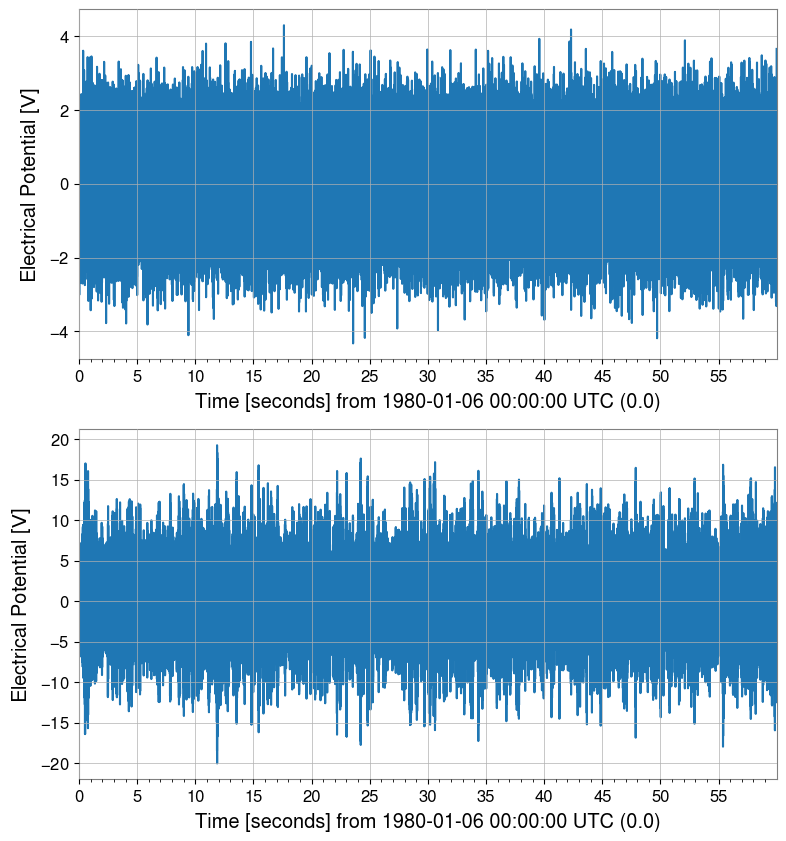

In [2]:
# --- Parameter Settings ---
fs = 2048.0  # Sampling frequency [Hz]
duration = 60.0  # Duration [s]
f0_true = 300.0  # True resonance frequency [Hz]
Q_true = 50.0  # True quality factor

# --- Time axis and input signal ---
t = np.linspace(0, duration, int(duration * fs), endpoint=False)
input_data = np.random.normal(0, 1, size=len(t))  # White noise input

# --- Physical System Simulation (using scipy.signal) ---
# Transfer function H(s) = w0^2 / (s^2 + (w0/Q)s + w0^2)
w0 = 2 * np.pi * f0_true
num = [w0**2]
den = [1, w0 / Q_true, w0**2]
system = signal.TransferFunction(num, den)

# Calculate time response (lsim)
# Time steps for simulation
_, output_clean, _ = signal.lsim(system, U=input_data, T=t)

# --- Add measurement noise ---
# Assume that the output has some noise (such as sensor noise)
measurement_noise = np.random.normal(0, 0.1, size=len(t))
output_data = output_clean + measurement_noise

# --- Create gwexpy TimeSeries objects ---
ts_input = TimeSeries(input_data, t0=0, sample_rate=fs, name="Input", unit="V")
ts_output = TimeSeries(output_data, t0=0, sample_rate=fs, name="Output", unit="V")

print("Input data shape:", ts_input.shape)
print("Output data shape:", ts_output.shape)
Plot(ts_input, ts_output, separate=True);

## 2. Transfer Function Estimation

From the input-output time series data `ts_input` and `ts_output`, we estimate the frequency response function (transfer function).
We use the `transfer_function` method of `gwexpy`.

We also calculate the **coherence** to assess the reliability of the measurement.
Frequency bands where the coherence is close to 1 indicate that the input-output relationship is linear and the influence of noise is small.

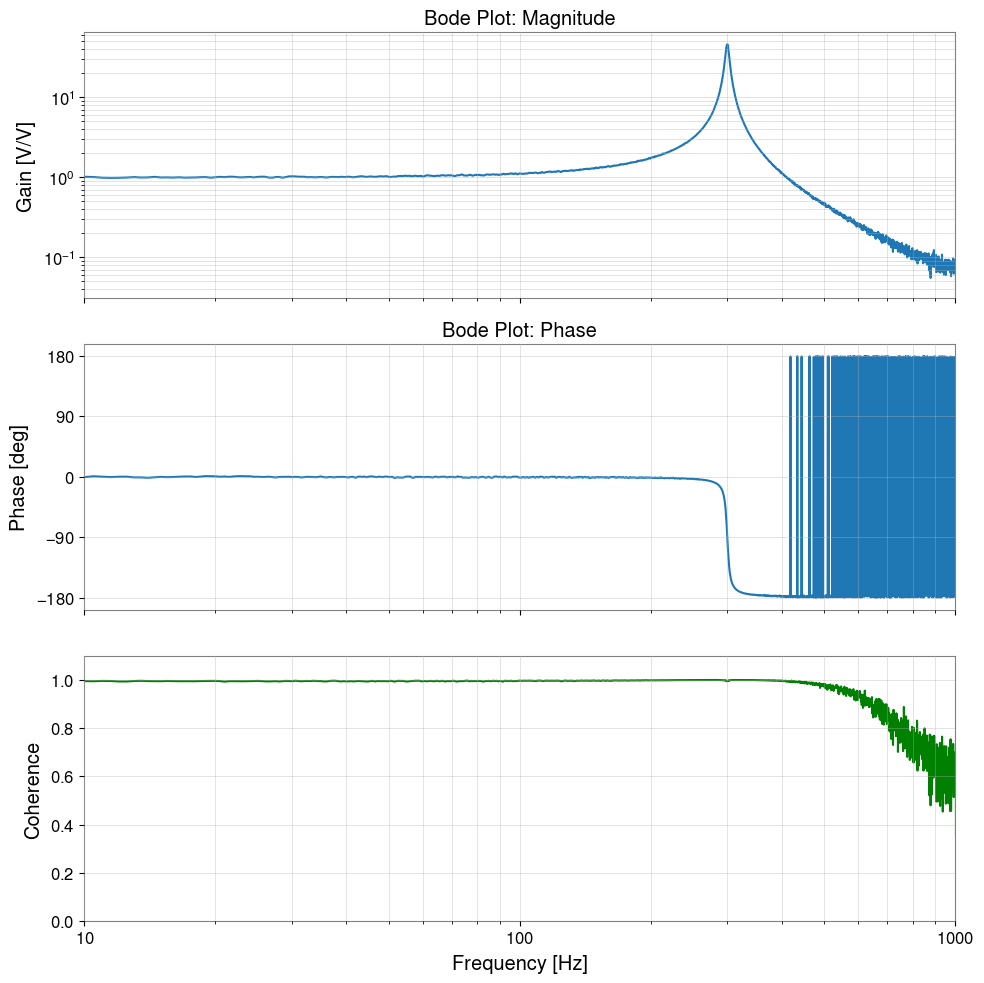

In [3]:
# FFT settings: specify the segment length for averaging
fftlength = 2.0  # FFT every 2 seconds and average

# Calculate transfer function (Output / Input)
tf = ts_input.transfer_function(ts_output, fftlength=fftlength)

# Calculate coherence
coh = ts_input.coherence(ts_output, fftlength=fftlength) ** 0.5

# --- Plotting (Bode Plot & Coherence) ---
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Magnitude
ax = axes[0]
ax.loglog(tf.abs(), label="Measured TF")
ax.set_ylabel("Gain [V/V]")
ax.set_title("Bode Plot: Magnitude")
ax.grid(True, which="both", alpha=0.5)

# Phase
ax = axes[1]
ax.plot(tf.degree(), label="Measured Phase")
ax.set_ylabel("Phase [deg]")
ax.set_title("Bode Plot: Phase")
ax.set_yticks(np.arange(-180, 181, 90))
ax.grid(True, which="both", alpha=0.5)

# Coherence
ax = axes[2]
ax.plot(coh, color="green", label="Coherence")
ax.set_ylabel("Coherence")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylim(0, 1.1)
ax.set_xlim(10, 1000)
ax.grid(True, which="both", alpha=0.5)

plt.tight_layout()
plt.show()

## 3. Model Fitting

We fit a theoretical model to the obtained transfer function (especially around the resonance).
Here, we define a transfer function model for a harmonic oscillator and use least-squares fitting to determine the parameters ($A, f_0, Q$).

Model equation (including gain $A$):
$$ H(f) = A \cdot \frac{f_0^2}{f_0^2 - f^2 + i (f f_0 / Q)} $$

In [4]:
# --- Define model function for fitting ---
def resonator_model(f, amp, f0, Q):
    # f: frequency array
    # Parameters: amp(gain), f0(resonance frequency), Q(quality factor)

    # Calculation formula (complex number)
    numerator = amp * (f0**2)
    denominator = (f0**2) - (f**2) + 1j * (f * f0 / Q)
    return numerator / denominator


# --- Perform fitting ---
# If we use all the data, fitting may be difficult due to the wide bandwidth,
# so we crop the data to around the resonance (100Hz ~ 500Hz).
tf_crop = tf.crop(100, 500)

# Estimate initial values (determined by visual inspection or peak search)
# Here, we use f0=300 as the initial value since it appears to be around there
p0 = {"amp": 1.0, "f0": 300.0, "Q": 10.0}

# Execute fitting
# The .fit() method of FrequencySeries fits both real and imaginary parts simultaneously for complex data
result = tf_crop.fit(resonator_model, p0=p0)

print(result)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.629 (χ²/ndof = 0.0)      │              Nfcn = 116              │
│ EDM = 6.77e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

## 4. Verification of Results

We verify the fitting results numerically and plot them overlaid on the measured data.
The `FitResult.plot()` method automatically generates a Bode plot (magnitude and phase) for complex data.

--- Estimated Parameters ---
Resonance Frequency (f0): 299.9979 Hz (True: 300.0)
Quality Factor (Q):       49.5977      (True: 50.0)
Gain (Amp):               0.9345


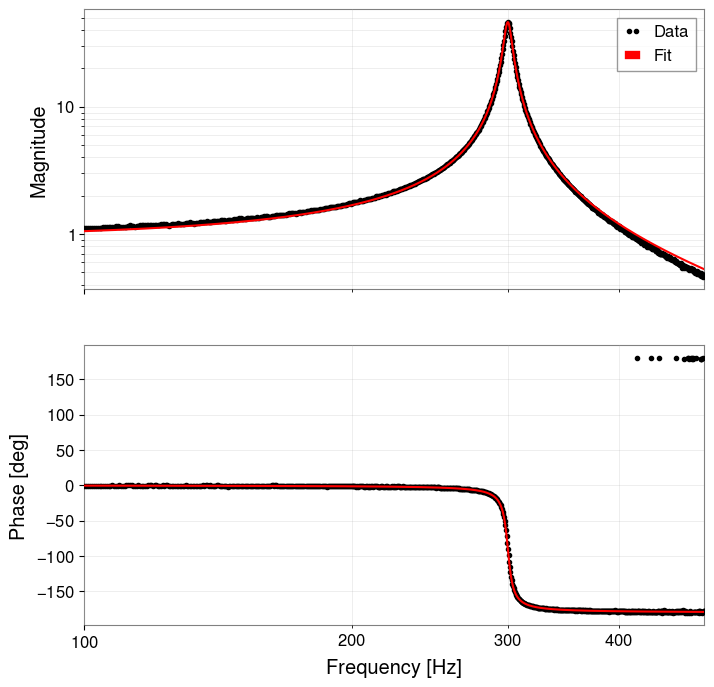

In [5]:
# --- Display results ---
print("--- Estimated Parameters ---")
print(f"Resonance Frequency (f0): {result.params['f0']:.4f} Hz (True: {f0_true})")
print(f"Quality Factor (Q):       {result.params['Q']:.4f}      (True: {Q_true})")
print(f"Gain (Amp):               {result.params['amp']:.4f}")

# --- Plotting ---
# result.plot() returns two Axes for magnitude and phase in the case of complex numbers
axes = result.plot()
plt.show()